In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# 1. Load dataset
# wdbc.data does not have headers, so we define them
columns = ["ID", "Diagnosis"] + [f"feature_{i}" for i in range(1, 31)]
data = pd.read_csv("wdbc.data", header=None, names=columns)

In [3]:
# 2. Prepare features and target
X = data.drop(["ID", "Diagnosis"], axis=1)
y = data["Diagnosis"].map({"M": 1, "B": 0})  # Malignant=1, Benign=0

In [4]:

# 4. Preprocessor (scaling not needed for trees, but kept for pipeline consistency)
num_features = X.columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[("scale", StandardScaler(), num_features)],
    remainder="drop"
)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", GradientBoostingClassifier(random_state=42))
])

In [7]:
param_grid = {
    "clf__n_estimators": [50, 100, 200],
    "clf__learning_rate": [0.01, 0.1, 0.2],
    "clf__max_depth": [3, 5, 7],
    "clf__subsample": [0.8, 1.0]
}

In [8]:
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring={"accuracy": "accuracy", "f1": "f1_macro"},  # track both
    refit="accuracy",   # choose best by accuracy
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'clf__learning_rate': [0.01, 0.1, ...], 'clf__max_depth': [3, 5, ...], 'clf__n_estimators': [50, 100, ...], 'clf__subsample': [0.8, 1.0]}"
,scoring,"{'accuracy': 'accuracy', 'f1': 'f1_macro'}"
,n_jobs,-1
,refit,'accuracy'
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [9]:
gb_results = pd.DataFrame(grid.cv_results_)

gb_table = gb_results[[
    "param_clf__n_estimators",
    "param_clf__learning_rate",
    "param_clf__max_depth",
    "param_clf__subsample",
    "mean_test_accuracy",
    "mean_test_f1"
]].copy()

gb_table = gb_table.rename(columns={
    "param_clf__n_estimators": "n_estimators",
    "param_clf__learning_rate": "learning_rate",
    "param_clf__max_depth": "max_depth",
    "param_clf__subsample": "subsample",
    "mean_test_accuracy": "Accuracy",
    "mean_test_f1": "F1_score"
})

print("Gradient Boosting Model")
print("Hyperparameter Trials")
print("Table 3: Gradient Boosting - Hyperparameter Tuning")
print(gb_table.head(20)[["n_estimators", "learning_rate", "max_depth", "subsample", "Accuracy", "F1_score"]])


Gradient Boosting Model
Hyperparameter Trials
Table 3: Gradient Boosting - Hyperparameter Tuning
    n_estimators  learning_rate  max_depth  subsample  Accuracy  F1_score
0             50           0.01          3        0.8  0.934066  0.927601
1             50           0.01          3        1.0  0.918681  0.911417
2            100           0.01          3        0.8  0.938462  0.933295
3            100           0.01          3        1.0  0.927473  0.921360
4            200           0.01          3        0.8  0.951648  0.948168
5            200           0.01          3        1.0  0.942857  0.938618
6             50           0.01          5        0.8  0.929670  0.923099
7             50           0.01          5        1.0  0.929670  0.923914
8            100           0.01          5        0.8  0.940659  0.935761
9            100           0.01          5        1.0  0.931868  0.926376
10           200           0.01          5        0.8  0.951648  0.947866
11           20

In [10]:
# 7. Get best estimator
best_gb = grid.best_estimator_

print("Best Parameters:", grid.best_params_)

# 8. Retrain on training set (already fitted in grid, but we can refit)
best_gb.fit(X_train, y_train)

# 9. Evaluate on test set
y_pred = best_gb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nFinal Evaluation on Test Set")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")


Best Parameters: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__subsample': 0.8}

Final Evaluation on Test Set
Accuracy: 0.9649
F1 Score: 0.9500


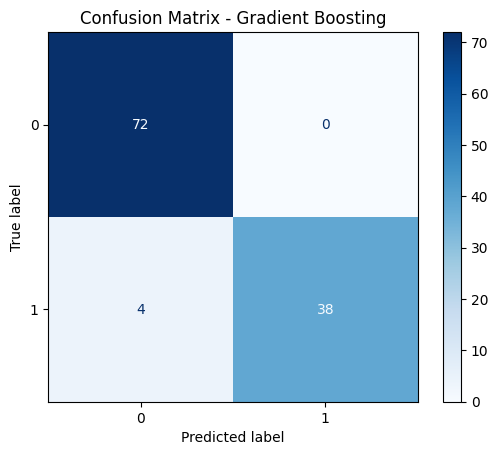

/tmp/ipykernel_35255/2417571647.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp, y=feat_imp.index, palette="viridis")


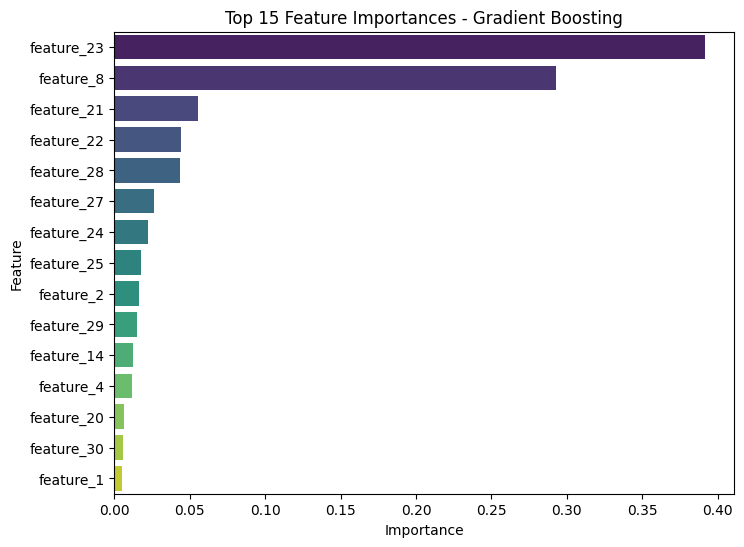

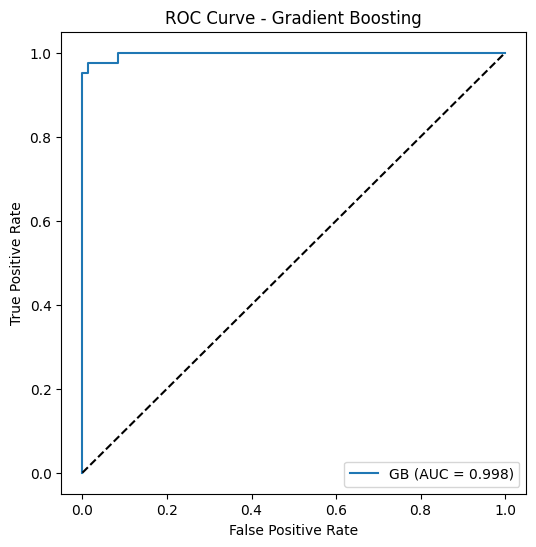

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# --- Confusion Matrix ---
ConfusionMatrixDisplay.from_estimator(best_gb, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()

# --- Feature Importances ---
importances = best_gb.named_steps["clf"].feature_importances_
feature_names = X.columns  # original feature names
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:15]

plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp, y=feat_imp.index, palette="viridis")
plt.title("Top 15 Feature Importances - Gradient Boosting")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# --- ROC Curve & AUC ---
y_prob = best_gb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"GB (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Gradient Boosting")
plt.legend()
plt.show()


In [13]:
# --- Get best hyperparameters index ---
best_index = grid.best_index_

# --- Extract per-fold accuracy for the best model ---
best_fold_acc = [grid.cv_results_[f"split{i}_test_accuracy"][best_index] for i in range(5)]

# Compute mean accuracy
mean_acc = sum(best_fold_acc) / len(best_fold_acc)

print("Gradient Boosting - 5 Fold CV Accuracy (Best Hyperparameters)")
for i, acc in enumerate(best_fold_acc, 1):
    print(f"Fold {i}: {acc:.4f}")

print(f"Mean Accuracy: {mean_acc:.4f}")


Gradient Boosting - 5 Fold CV Accuracy (Best Hyperparameters)
Fold 1: 0.9780
Fold 2: 1.0000
Fold 3: 0.9451
Fold 4: 0.9890
Fold 5: 0.9341
Mean Accuracy: 0.9692
